In [ ]:
import pandas as pd
import numpy as np
import json
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import joblib
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


c:\Users\srini\.conda\envs\tf\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\srini\.conda\envs\tf\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to ma

In [28]:
np.random.seed(42)
tf.random.set_seed(42)

In [29]:
def load_dataset(csv_file="cleaned_dataset.csv"):
    """Load the labeled dataset from CSV file"""
    print(f"Loading dataset from: {csv_file}")
    df = pd.read_csv(csv_file)
    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    return df

In [30]:
# Feature engineering
def create_features(df):
    """Create features from the PDF extraction data"""
    # Handle bbox column if it's a string representation of list
    if 'bbox' in df.columns and df['bbox'].dtype == 'object':
        try:
            # Try to parse bbox if it's stored as string
            df['bbox'] = df['bbox'].apply(lambda x: eval(x) if isinstance(x, str) and x.startswith('[') else x)
        except:
            pass
    
    # Create additional features
    df['text_length'] = df['text'].str.len()
    df['word_count'] = df['text'].str.split().str.len()
    
    # Handle bbox features
    if 'bbox' in df.columns:
        df['bbox_width'] = df['bbox'].apply(lambda x: x[2] - x[0] if isinstance(x, (list, tuple)) and len(x) >= 4 else 0)
        df['bbox_height'] = df['bbox'].apply(lambda x: x[3] - x[1] if isinstance(x, (list, tuple)) and len(x) >= 4 else 0)
    else:
        df['bbox_width'] = 0
        df['bbox_height'] = 0
    
    df['bbox_area'] = df['bbox_width'] * df['bbox_height']
    
    # Text alignment encoding - handle different column naming conventions
    text_align_col = None
    for col in ['attributes_TextAlign', 'TextAlign', 'text_align']:
        if col in df.columns:
            text_align_col = col
            break
    
    if text_align_col:
        df['is_center_aligned'] = (df[text_align_col] == 'Center').astype(int)
        df['is_left_aligned'] = (df[text_align_col] == 'Left').astype(int)
    else:
        df['is_center_aligned'] = 0
        df['is_left_aligned'] = 1
    
    # Font properties - handle different column naming conventions
    font_weight_col = None
    for col in ['Font_weight', 'font_weight', 'weight']:
        if col in df.columns:
            font_weight_col = col
            break
    
    font_italic_col = None
    for col in ['Font_italic', 'font_italic', 'italic']:
        if col in df.columns:
            font_italic_col = col
            break
    
    if font_weight_col:
        df['is_bold'] = (pd.to_numeric(df[font_weight_col], errors='coerce').fillna(400) >= 700).astype(int)
    else:
        df['is_bold'] = 0
    
    if font_italic_col:
        df['is_italic'] = df[font_italic_col].astype(int)
    else:
        df['is_italic'] = 0
    
    return df

In [31]:
def prepare_data(df):
    """Prepare data for training"""
    # Define potential feature columns (flexible to handle different CSV formats)
    potential_features = [
        'font_size', 'Font_weight', 'font_weight', 'weight',
        'page', 'x_center', 'y_center',
        'attributes_LineHeight', 'LineHeight', 'line_height',
        'text_length', 'word_count',
        'bbox_width', 'bbox_height', 'bbox_area',
        'is_center_aligned', 'is_left_aligned', 'is_bold', 'is_italic'
    ]
    
    # Select features that exist in the dataset
    feature_cols = []
    for col in potential_features:
        if col in df.columns:
            feature_cols.append(col)
    
    # Ensure we have the essential features
    essential_features = ['font_size', 'page', 'text_length', 'word_count']
    for essential in essential_features:
        if essential not in feature_cols and essential in df.columns:
            feature_cols.append(essential)
    
    # Add default values for missing features
    for col in feature_cols:
        if col not in df.columns:
            df[col] = 0
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)
    
    print(f"Using features: {feature_cols}")
    
    X = df[feature_cols].values
    y = df['label'].values
    
    return X, y, feature_cols

In [32]:
print("Loading dataset...")
df = load_dataset()
print(f"Loaded {len(df)} samples")

Loading dataset...
Loading dataset from: cleaned_dataset.csv
Dataset shape: (18468, 23)
Columns: ['Font_alt_family_name', 'Font_embedded', 'Font_encoding', 'Font_family_name', 'Font_font_type', 'Font_italic', 'Font_monospaced', 'Font_name', 'Font_subset', 'Font_weight', 'Lang', 'attributes_LineHeight', 'attributes_SpaceAfter', 'attributes_TextAlign', 'bbox', 'font_name', 'font_size', 'label', 'level', 'page', 'text', 'x_center', 'y_center']
Loaded 18468 samples


In [33]:
print("Creating features...")
df = create_features(df)

Creating features...


In [34]:
X, y, feature_cols = prepare_data(df)

Using features: ['font_size', 'Font_weight', 'page', 'x_center', 'y_center', 'attributes_LineHeight', 'text_length', 'word_count', 'bbox_width', 'bbox_height', 'bbox_area', 'is_center_aligned', 'is_left_aligned', 'is_bold', 'is_italic']


In [35]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
n_classes = len(label_encoder.classes_)

print(f"Classes: {label_encoder.classes_}")
print(f"Feature columns: {feature_cols}")

Classes: ['Body' 'H1' 'H2' 'H3' 'H4' 'Other' 'title']
Feature columns: ['font_size', 'Font_weight', 'page', 'x_center', 'y_center', 'attributes_LineHeight', 'text_length', 'word_count', 'bbox_width', 'bbox_height', 'bbox_area', 'is_center_aligned', 'is_left_aligned', 'is_bold', 'is_italic']


In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


In [37]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [38]:
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(n_classes, activation='softmax')
])

In [41]:
model.compile(
    optimizer=tfa.keras.optimizers.AdamW(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

AttributeError: module 'tensorflow_addons' has no attribute 'keras'

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2048      
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [ ]:

early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, min_lr=1e-5)


In [ ]:
print("Training model...")
history = model.fit(
    X_train_scaled, y_train,
    epochs=500,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Training model...
Epoch 1/250
370/370 [==============================] - 4s 6ms/step - loss: 1.4252 - accuracy: 0.4964 - val_loss: 0.9499 - val_accuracy: 0.6765 - lr: 0.0010
Epoch 2/250
370/370 [==============================] - 2s 4ms/step - loss: 1.0400 - accuracy: 0.6255 - val_loss: 0.8289 - val_accuracy: 0.7039 - lr: 0.0010
Epoch 3/250
370/370 [==============================] - 2s 5ms/step - loss: 0.9449 - accuracy: 0.6523 - val_loss: 0.7782 - val_accuracy: 0.7036 - lr: 0.0010
Epoch 4/250
370/370 [==============================] - 2s 5ms/step - loss: 0.8944 - accuracy: 0.6642 - val_loss: 0.7373 - val_accuracy: 0.7171 - lr: 0.0010
Epoch 5/250
370/370 [==============================] - 1s 4ms/step - loss: 0.8536 - accuracy: 0.6823 - val_loss: 0.7012 - val_accuracy: 0.7394 - lr: 0.0010
Epoch 6/250
370/370 [==============================] - 1s 4ms/step - loss: 0.8281 - accuracy: 0.6873 - val_loss: 0.6842 - val_accuracy: 0.7469 - lr: 0.0010
Epoch 7/250
370/370 [=========================

In [ ]:
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_classes)
print(f"\nTest Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, 
                          target_names=label_encoder.classes_))

116/116 [==============================] - 1s 2ms/step

Test Accuracy: 0.7986

Classification Report:
              precision    recall  f1-score   support

        Body       0.82      0.97      0.89      1899
          H1       0.72      0.81      0.76       251
          H2       0.66      0.57      0.61       260
          H3       0.71      0.51      0.60       280
          H4       0.92      0.38      0.53       274
       Other       0.81      0.62      0.70       529
       title       0.86      0.92      0.89       201

    accuracy                           0.80      3694
   macro avg       0.78      0.68      0.71      3694
weighted avg       0.80      0.80      0.78      3694



In [ ]:
print("Saving model and preprocessors...")
model.save('section_classifier_model.h5')
joblib.dump(scaler, 'feature_scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')
joblib.dump(feature_cols, 'feature_columns.pkl')

Saving model and preprocessors...


['feature_columns.pkl']

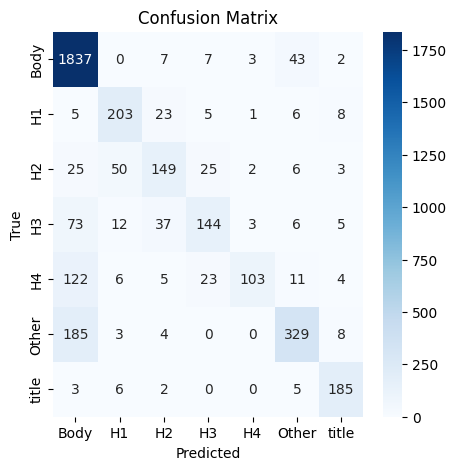

In [ ]:
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_classes, average=None)
metrics_df = pd.DataFrame({
    'Class': label_encoder.classes_,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}).melt(id_vars='Class', var_name='Metric')

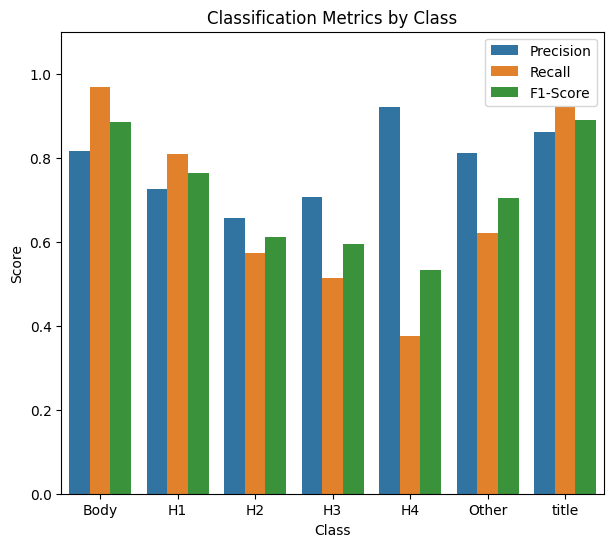

In [ ]:
plt.figure(figsize=(7,6))
sns.barplot(data=metrics_df, x='Class', y='value', hue='Metric')
plt.title('Classification Metrics by Class')
plt.ylabel('Score')
plt.ylim(0, 1.1)
plt.legend(loc='upper right')
plt.show()

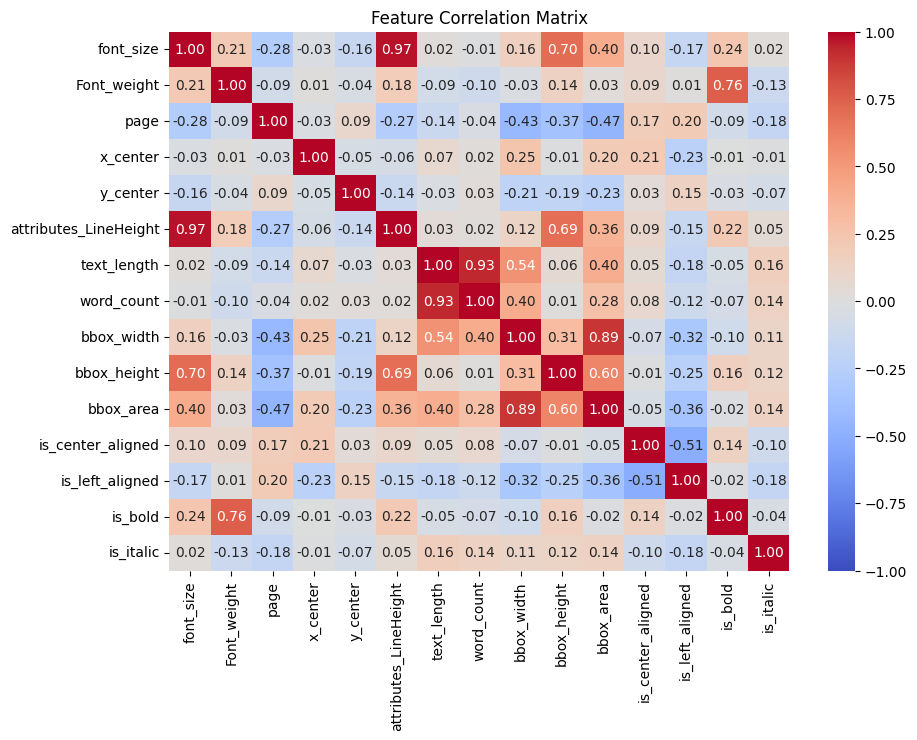

In [ ]:
corr_matrix = pd.DataFrame(X_train_scaled, columns=feature_cols).corr()
plt.figure(figsize=(10,7))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.show()

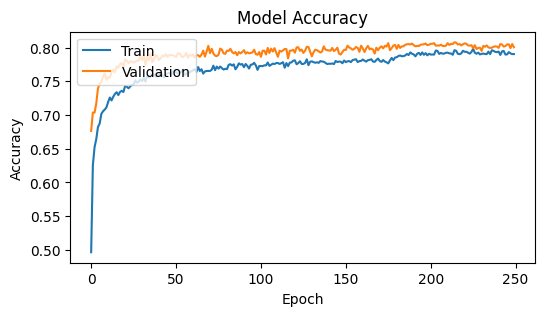

In [ ]:
plt.figure(figsize=(6,3))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

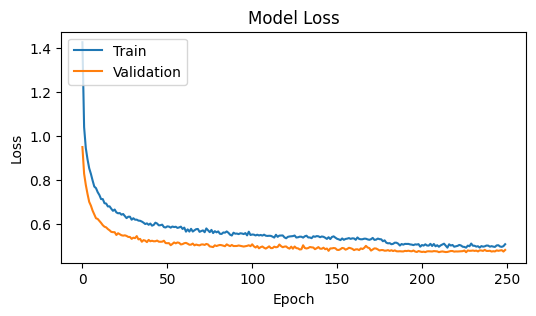

In [ ]:
plt.figure(figsize=(6,3))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

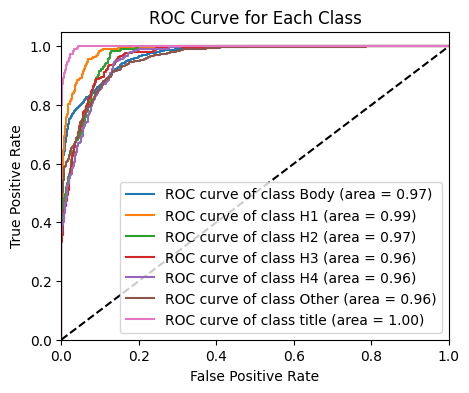

In [ ]:
# Binarize the output for multiclass
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(5,4))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], 
             label=f'ROC curve of class {label_encoder.classes_[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()

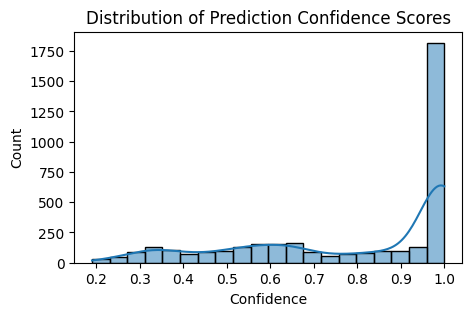

In [ ]:
plt.figure(figsize=(5,3))
sns.histplot(np.max(y_pred, axis=1), bins=20, kde=True)
plt.title('Distribution of Prediction Confidence Scores')
plt.xlabel('Confidence')
plt.ylabel('Count')
plt.show()